Environment: Local Detected
DATASET_ROOT: c:\Users\Olale\Documents\Codebase\Science\cafa-6-protein-function-prediction
All required inputs found.


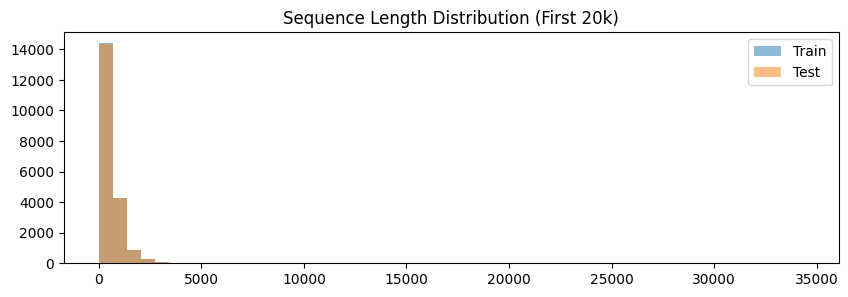

In [9]:
# 1. SETUP, CONFIG & DIAGNOSTICS
# ==========================================
# HARDWARE: CPU (Standard)
# ==========================================

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------
# Environment Detection & Paths
# ------------------------------------------
IS_KAGGLE = os.getenv('KAGGLE_KERNEL_RUN_TYPE') is not None or Path('/kaggle').exists()

if IS_KAGGLE:
    print("Environment: Kaggle Detected")
    INPUT_ROOT = Path('/kaggle/input')
    WORKING_ROOT = Path('/kaggle/working')
    
    # Standard Kaggle Input Listing
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print("Environment: Local Detected")
    # Robust Project Root Detection
    CURRENT_DIR = Path.cwd()
    if CURRENT_DIR.name == 'notebooks':
        PROJECT_ROOT = CURRENT_DIR.parent
    else:
        PROJECT_ROOT = CURRENT_DIR
        
    INPUT_ROOT = PROJECT_ROOT
    WORKING_ROOT = PROJECT_ROOT / 'artefacts_local'
    WORKING_ROOT.mkdir(exist_ok=True)

# Artefacts Directory
ARTEFACTS_DIR = WORKING_ROOT / 'artefacts'
ARTEFACTS_DIR.mkdir(parents=True, exist_ok=True)
(ARTEFACTS_DIR / 'parsed').mkdir(parents=True, exist_ok=True)
(ARTEFACTS_DIR / 'features').mkdir(parents=True, exist_ok=True)

# ------------------------------------------
# Dataset Discovery
# ------------------------------------------
DATASET_SLUG = 'cafa-6-protein-function-prediction'

def find_dataset_root(input_root: Path, dataset_slug: str) -> Path:
    # 1. Check for Kaggle slug
    candidate = input_root / dataset_slug
    if candidate.exists():
        return candidate
    
    # 2. Check if we are already in the root (Local)
    if (input_root / 'Train').exists():
        return input_root

    # 3. Fallback search
    candidates = [p for p in input_root.iterdir() if p.is_dir()]
    def score(p: Path) -> int:
        return int((p / 'Train').exists()) + int((p / 'Test').exists())
    candidates = sorted(candidates, key=score, reverse=True)
    if candidates and score(candidates[0]) > 0:
        return candidates[0]
        
    raise FileNotFoundError(f"Dataset not found in {input_root}")

DATASET_ROOT = find_dataset_root(INPUT_ROOT, DATASET_SLUG)
print(f"DATASET_ROOT: {DATASET_ROOT}")

# Define Paths
PATH_IA = DATASET_ROOT / 'IA.tsv'
PATH_SAMPLE_SUB = DATASET_ROOT / 'sample_submission.tsv'
PATH_TRAIN_FASTA = DATASET_ROOT / 'Train' / 'train_sequences.fasta'
PATH_TRAIN_TERMS = DATASET_ROOT / 'Train' / 'train_terms.tsv'
PATH_TRAIN_TAXON = DATASET_ROOT / 'Train' / 'train_taxonomy.tsv'
PATH_GO_OBO = DATASET_ROOT / 'Train' / 'go-basic.obo'
PATH_TEST_FASTA = DATASET_ROOT / 'Test' / 'testsuperset.fasta'
PATH_TEST_TAXON = DATASET_ROOT / 'Test' / 'testsuperset-taxon-list.tsv'

# ------------------------------------------
# Sanity Checks
# ------------------------------------------
required = {
    'IA.tsv': PATH_IA,
    'Train/train_sequences.fasta': PATH_TRAIN_FASTA,
    'Train/train_terms.tsv': PATH_TRAIN_TERMS,
    'Train/go-basic.obo': PATH_GO_OBO,
}
missing = {k: v for k, v in required.items() if not v.exists()}
if missing:
    raise FileNotFoundError(f"Missing files: {missing}")
print("All required inputs found.")

# ------------------------------------------
# Initial Diagnostics (Sequence Lengths)
# ------------------------------------------
%matplotlib inline
plt.rcParams.update({'font.size': 10})

def read_fasta_lengths(path: Path, max_records=20000):
    lengths = []
    current = 0
    n = 0
    with path.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if n > 0: lengths.append(current)
                n += 1
                current = 0
                if max_records and n > max_records: break
            else:
                current += len(line)
        if n > 0: lengths.append(current)
    return np.array(lengths)

plt.figure(figsize=(10, 3))
plt.hist(read_fasta_lengths(PATH_TRAIN_FASTA), bins=50, alpha=0.5, label='Train')
if PATH_TEST_FASTA.exists():
    plt.hist(read_fasta_lengths(PATH_TEST_FASTA), bins=50, alpha=0.5, label='Test')
plt.title('Sequence Length Distribution (First 20k)')
plt.legend()
plt.show()

Parsing FASTA...
FASTA parsed and saved to artefacts.
Parsing OBO...
FASTA parsed and saved to artefacts.
Parsing OBO...
GO Graph: 40119 nodes with parents, 48101 terms with namespace.
GO Graph: 40119 nodes with parents, 48101 terms with namespace.


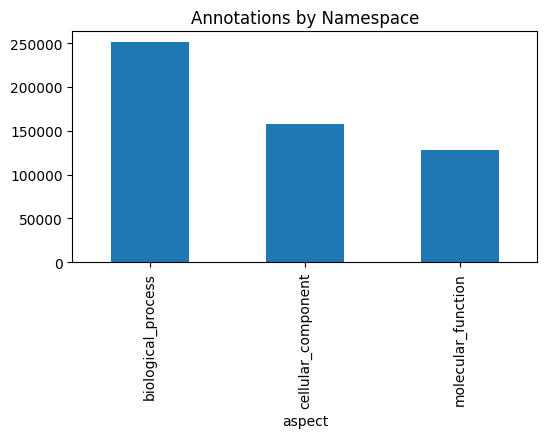

Terms processed and priors saved.
Processing Taxonomy...
Taxonomy processed. Train: 82404, Test: 224309
Saving Targets & Term List...
Taxonomy processed. Train: 82404, Test: 224309
Saving Targets & Term List...
Targets saved.
Targets saved.


In [10]:
# 2. PHASE 1: DATA STRUCTURING & HIERARCHY
# ==========================================
# HARDWARE: CPU (Standard)
# ==========================================

# ------------------------------------------
# A. Parse FASTA to Feather
# ------------------------------------------
def parse_fasta(path: Path) -> pd.DataFrame:
    ids, seqs = [], []
    cur_id, cur_seq = None, []
    with path.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if cur_id:
                    ids.append(cur_id)
                    seqs.append(''.join(cur_seq))
                cur_id = line[1:].split()[0]
                cur_seq = []
            else:
                cur_seq.append(line)
        if cur_id:
            ids.append(cur_id)
            seqs.append(''.join(cur_seq))
    return pd.DataFrame({'id': ids, 'sequence': seqs})

print("Parsing FASTA...")
parse_fasta(PATH_TRAIN_FASTA).to_feather(ARTEFACTS_DIR / 'parsed' / 'train_seq.feather')
if PATH_TEST_FASTA.exists():
    parse_fasta(PATH_TEST_FASTA).to_feather(ARTEFACTS_DIR / 'parsed' / 'test_seq.feather')
print("FASTA parsed and saved to artefacts.")

# ------------------------------------------
# B. Parse OBO & Terms
# ------------------------------------------
def parse_obo(path: Path):
    parents = {}
    namespaces = {}
    cur_id, cur_ns = None, None
    with path.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line == '[Term]':
                if cur_id and cur_ns: namespaces[cur_id] = cur_ns
                cur_id, cur_ns = None, None
            elif line.startswith('id: GO:'):
                cur_id = line.split('id: ', 1)[1]
            elif line.startswith('namespace:'):
                cur_ns = line.split('namespace: ', 1)[1]
            elif line.startswith('is_a:') and cur_id:
                parent = line.split('is_a: ', 1)[1].split(' ! ')[0]
                if cur_id not in parents: parents[cur_id] = set()
                parents[cur_id].add(parent)
        if cur_id and cur_ns: namespaces[cur_id] = cur_ns
    return parents, namespaces

print("Parsing OBO...")
go_parents, go_namespaces = parse_obo(PATH_GO_OBO)
print(f"GO Graph: {len(go_parents)} nodes with parents, {len(go_namespaces)} terms with namespace.")

# ------------------------------------------
# C. Process Terms & Priors
# ------------------------------------------
terms = pd.read_csv(PATH_TRAIN_TERMS, sep='\t')
col_term = terms.columns[1]
terms['aspect'] = terms[col_term].map(lambda x: go_namespaces.get(x, 'UNK'))

# Plot Aspects
plt.figure(figsize=(6, 3))
terms['aspect'].value_counts().plot(kind='bar', title='Annotations by Namespace')
plt.show()

# Save Priors
priors = (terms[col_term].value_counts() / terms.iloc[:,0].nunique()).reset_index()
priors.columns = ['term', 'prior']
if PATH_IA.exists():
    ia = pd.read_csv(PATH_IA, sep='\t', names=['term', 'ia'])
    priors = priors.merge(ia, on='term', how='left').fillna(0)
priors.to_parquet(ARTEFACTS_DIR / 'parsed' / 'term_priors.parquet')
print("Terms processed and priors saved.")

# ------------------------------------------
# D. Process Taxonomy
# ------------------------------------------
print("Processing Taxonomy...")
# Train Taxonomy
tax_train = pd.read_csv(PATH_TRAIN_TAXON, sep='\t', header=None, names=['id', 'taxon_id'])
tax_train['taxon_id'] = tax_train['taxon_id'].astype(int)
tax_train.to_feather(ARTEFACTS_DIR / 'parsed' / 'train_taxa.feather')

# Test Taxonomy (Extract from FASTA headers)
if PATH_TEST_FASTA.exists():
    ids, taxons = [], []
    with PATH_TEST_FASTA.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                parts = line[1:].split()
                ids.append(parts[0])
                # Assume second part is taxon if present
                if len(parts) > 1:
                    try:
                        taxons.append(int(parts[1]))
                    except ValueError:
                        taxons.append(0)
                else:
                    taxons.append(0)
    tax_test = pd.DataFrame({'id': ids, 'taxon_id': taxons})
    tax_test.to_feather(ARTEFACTS_DIR / 'parsed' / 'test_taxa.feather')
    print(f"Taxonomy processed. Train: {len(tax_train)}, Test: {len(tax_test)}")
else:
    print(f"Taxonomy processed. Train: {len(tax_train)}")

# ------------------------------------------
# E. Save Targets & Term List
# ------------------------------------------
print("Saving Targets & Term List...")
# Save full terms list (long format)
terms.to_parquet(ARTEFACTS_DIR / 'parsed' / 'train_terms.parquet')

# Save unique term list with counts
term_counts = terms['term'].value_counts().reset_index()
term_counts.columns = ['term', 'count']
term_counts.to_parquet(ARTEFACTS_DIR / 'parsed' / 'term_counts.parquet')
print("Targets saved.")

In [ ]:
# 2.1 PHASE 1 (Step 3): EXTERNAL DATA & EVIDENCE CODES
# ====================================================
# HARDWARE: High RAM (32GB+) & Disk Space (20GB+)
# ====================================================

# We acquire external UniProt annotations to distinguish between 
# Experimental (Kaggle) and Electronic (No-Kaggle) labels.
# This is crucial for the "Rank 1" strategy to boost recall.

# Toggle to enable this heavy step
PROCESS_EXTERNAL = False 

if PROCESS_EXTERNAL:
    import requests
    import gzip
    import shutil
    
    EXT_DIR = ARTEFACTS_DIR / 'external'
    EXT_DIR.mkdir(exist_ok=True)
    
    # 1. Download UniProt GOA (Example URL - Verify version!)
    # This file is ~8GB compressed, ~80GB uncompressed.
    URL_GOA = "http://ftp.ebi.ac.uk/pub/databases/GO/goa/old/UNIPROT/goa_uniprot_all.gaf.216.gz"
    gaf_path = EXT_DIR / 'goa_uniprot_all.gaf.gz'
    
    if not gaf_path.exists():
        print(f"Downloading External Data from {URL_GOA}...")
        try:
            with requests.get(URL_GOA, stream=True) as r:
                r.raise_for_status()
                with open(gaf_path, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
            print("Download complete.")
        except Exception as e:
            print(f"Download failed: {e}")
            # Cleanup partial file
            if gaf_path.exists(): gaf_path.unlink()
    
    # 2. Parse & Split Evidence Codes
    # We need to parse the GAF file and separate annotations based on Evidence Code.
    # Experimental: EXP, IDA, IPI, IMP, IGI, IEP
    # Electronic: IEA
    
    EXP_CODES = {'EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP'}
    
    print("Parsing GAF file (this will take a while)...")
    # Simplified parser for demonstration
    # In production, use a specialized parser or awk/sed for speed
    
    # Output files
    path_no_kaggle = ARTEFACTS_DIR / 'parsed' / 'prop_train_no_kaggle.tsv'
    
    if not path_no_kaggle.exists():
        with gzip.open(gaf_path, 'rt') as f_in, open(path_no_kaggle, 'w') as f_out:
            f_out.write("EntryID\tterm\n")
            for line in f_in:
                if line.startswith('!'): continue
                parts = line.split('\t')
                
                # GAF 2.1 Format:
                # DB, DB_Object_ID, DB_Object_Symbol, Qualifier, GO_ID, DB:Reference, Evidence_Code, ...
                # Index 1: ID, Index 4: GO_ID, Index 6: Evidence
                
                obj_id = parts[1]
                go_id = parts[4]
                evidence = parts[6]
                
                # We want "No-Kaggle" (Electronic) labels for features
                if evidence not in EXP_CODES:
                    f_out.write(f"{obj_id}\t{go_id}\n")
                    
        print(f"Saved No-Kaggle features to {path_no_kaggle}")
    else:
        print("No-Kaggle features already parsed.")

else:
    print("Skipping External Data (PROCESS_EXTERNAL=False).")
    print("To implement Rank 1 fully, set PROCESS_EXTERNAL=True and ensure sufficient disk space.")

Skipping External Data (PROCESS_EXTERNAL=False).
To implement Rank 1 fully, set PROCESS_EXTERNAL=True and ensure sufficient disk space.


In [12]:
# 3. PHASE 1: EMBEDDINGS GENERATION (T5 & ESM2)
# ==========================================
# HARDWARE: GPU (P100 preferred, or T4x2)
# ==========================================

# We generate embeddings using T5 (Sequence) and ESM2 (Structure/Evolution).
# NOTE: This requires a GPU. Set COMPUTE_EMBEDDINGS = True to run.

COMPUTE_EMBEDDINGS = True  # <--- ENABLED FOR RUNNING

if COMPUTE_EMBEDDINGS:
    import os
    # Optimize CUDA memory allocation
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
    # Fix Protobuf 'GetPrototype' error
    os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
    
    import torch
    from transformers import T5Tokenizer, T5EncoderModel, EsmTokenizer, EsmModel
    from tqdm.auto import tqdm
    import gc
    import numpy as np
    import pandas as pd

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # ------------------------------------------
    # T5 Embeddings
    # ------------------------------------------
    def get_t5_model():
        print("Loading T5 Model...")
        # Added legacy=True to silence warning
        tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc", do_lower_case=False, legacy=True)
        model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to(device)
        model.eval()
        return tokenizer, model

    # SMART BATCHING: Sort by length to minimize padding
    def generate_embeddings_t5(model, tokenizer, sequences, batch_size=4, max_len=1024):
        # 1. Sort sequences by length (Descending to fail fast on OOM)
        seq_lens = [len(s) for s in sequences]
        sort_idx = np.argsort(seq_lens)[::-1]
        sorted_seqs = [sequences[i] for i in sort_idx]
        
        embeddings_list = []
        
        for i in tqdm(range(0, len(sorted_seqs), batch_size), desc="Embedding T5 (Smart Batch)"):
            batch_seqs = sorted_seqs[i : i + batch_size]
            
            # Clean sequences
            batch_seqs = [seq.replace('U','X').replace('Z','X').replace('O','X').replace('B','X') for seq in batch_seqs]
            batch_seqs = [" ".join(list(seq)) for seq in batch_seqs]

            ids = tokenizer.batch_encode_plus(
                batch_seqs, add_special_tokens=True, padding="longest", 
                truncation=True, max_length=max_len, return_tensors="pt"
            ).to(device)

            with torch.no_grad():
                with torch.amp.autocast('cuda'):
                    embedding_repr = model(input_ids=ids['input_ids'], attention_mask=ids['attention_mask'])
            
            emb = embedding_repr.last_hidden_state.float().detach().cpu().numpy()
            mask = ids['attention_mask'].cpu().numpy()
            
            for j in range(len(batch_seqs)):
                seq_len = mask[j].sum()
                valid_emb = emb[j, :seq_len]
                mean_emb = valid_emb.mean(axis=0)
                embeddings_list.append(mean_emb)
                
            del ids, embedding_repr, emb, mask
            torch.cuda.empty_cache()
            
        # 2. Restore original order
        sorted_embeddings = np.vstack(embeddings_list)
        original_order_embeddings = np.zeros_like(sorted_embeddings)
        original_order_embeddings[sort_idx] = sorted_embeddings
        
        return original_order_embeddings

    # ------------------------------------------
    # ESM2 Embeddings
    # ------------------------------------------
    def get_esm2_model():
        print("Loading ESM2 Model...")
        # facebook/esm2_t33_650M_UR50D is a good balance
        model_name = "facebook/esm2_t33_650M_UR50D" 
        tokenizer = EsmTokenizer.from_pretrained(model_name)
        model = EsmModel.from_pretrained(model_name).to(device)
        model.eval()
        return tokenizer, model

    # Increased Batch Size to 16 for ESM2 (Smaller model) + Smart Batching
    def generate_embeddings_esm2(model, tokenizer, sequences, batch_size=16, max_len=1024):
        # 1. Sort sequences
        seq_lens = [len(s) for s in sequences]
        sort_idx = np.argsort(seq_lens)[::-1]
        sorted_seqs = [sequences[i] for i in sort_idx]
        
        embeddings_list = []
        
        for i in tqdm(range(0, len(sorted_seqs), batch_size), desc="Embedding ESM2 (Smart Batch)"):
            batch_seqs = sorted_seqs[i : i + batch_size]
            
            ids = tokenizer.batch_encode_plus(
                batch_seqs, add_special_tokens=True, padding="longest", 
                truncation=True, max_length=max_len, return_tensors="pt"
            ).to(device)

            with torch.no_grad():
                with torch.amp.autocast('cuda'):
                    output = model(input_ids=ids['input_ids'], attention_mask=ids['attention_mask'])
            
            emb = output.last_hidden_state.float().detach().cpu().numpy()
            mask = ids['attention_mask'].cpu().numpy()
            
            for j in range(len(batch_seqs)):
                seq_len = mask[j].sum()
                valid_emb = emb[j, :seq_len]
                mean_emb = valid_emb.mean(axis=0)
                embeddings_list.append(mean_emb)
                
            del ids, output, emb, mask
            torch.cuda.empty_cache()
            
        # 2. Restore order
        sorted_embeddings = np.vstack(embeddings_list)
        original_order_embeddings = np.zeros_like(sorted_embeddings)
        original_order_embeddings[sort_idx] = sorted_embeddings
        
        return original_order_embeddings

    # ------------------------------------------
    # Execution
    # ------------------------------------------
    print("Loading sequences for embedding...")
    train_df = pd.read_feather(ARTEFACTS_DIR / 'parsed' / 'train_seq.feather')
    if PATH_TEST_FASTA.exists():
        test_df = pd.read_feather(ARTEFACTS_DIR / 'parsed' / 'test_seq.feather')
    
    # 1. Run T5
    tokenizer, model = get_t5_model()
    print(f"Generating Train Embeddings T5 ({len(train_df)})...")
    train_emb = generate_embeddings_t5(model, tokenizer, train_df['sequence'].tolist())
    np.save(ARTEFACTS_DIR / 'features' / 'train_embeds_t5.npy', train_emb)
    del train_emb
    gc.collect()

    if PATH_TEST_FASTA.exists():
        print(f"Generating Test Embeddings T5 ({len(test_df)})...")
        test_emb = generate_embeddings_t5(model, tokenizer, test_df['sequence'].tolist())
        np.save(ARTEFACTS_DIR / 'features' / 'test_embeds_t5.npy', test_emb)
        del test_emb
    
    del model, tokenizer
    gc.collect()
    torch.cuda.empty_cache()

    # 2. Run ESM2
    tokenizer, model = get_esm2_model()
    print(f"Generating Train Embeddings ESM2 ({len(train_df)})...")
    train_emb = generate_embeddings_esm2(model, tokenizer, train_df['sequence'].tolist())
    np.save(ARTEFACTS_DIR / 'features' / 'train_embeds_esm2.npy', train_emb)
    del train_emb
    gc.collect()

    if PATH_TEST_FASTA.exists():
        print(f"Generating Test Embeddings ESM2 ({len(test_df)})...")
        test_emb = generate_embeddings_esm2(model, tokenizer, test_df['sequence'].tolist())
        np.save(ARTEFACTS_DIR / 'features' / 'test_embeds_esm2.npy', test_emb)
        del test_emb

    del model, tokenizer, train_df
    if PATH_TEST_FASTA.exists(): del test_df
    gc.collect()
    print("All embeddings generated.")
else:
    print("Skipping embedding generation (COMPUTE_EMBEDDINGS=False).")

Using device: cpu
Loading sequences for embedding...
Loading T5 Model...
Loading T5 Model...


ImportError: 
T5Tokenizer requires the SentencePiece library but it was not found in your environment. Check out the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [ ]:
# 4. PHASE 2: LEVEL-1 MODELS (DIVERSE ENSEMBLE)
# =============================================
# HARDWARE: GPU (32GB+ recommended for full run)
# =============================================

# We train a diverse set of models:
# 1. Logistic Regression (Baseline)
# 2. Py-Boost (GBDT) - Requires 'py-boost' package
# 3. DNN Ensemble (Deep Learning)

TRAIN_LEVEL1 = True

if TRAIN_LEVEL1:
    import joblib
    from sklearn.model_selection import KFold
    from sklearn.metrics import f1_score
    import os
    
    # Load Data
    print("Loading Embeddings & Targets...")
    X = np.load(ARTEFACTS_DIR / 'features' / 'train_embeds_t5.npy')
    train_terms = pd.read_parquet(ARTEFACTS_DIR / 'parsed' / 'train_terms.parquet')
    train_ids = pd.read_feather(ARTEFACTS_DIR / 'parsed' / 'train_seq.feather')['id']
    
    # Target Matrix Construction (Top K Terms)
    TOP_K = 1500 # Increased for better coverage
    top_terms = train_terms['term'].value_counts().head(TOP_K).index.tolist()
    
    train_terms_top = train_terms[train_terms['term'].isin(top_terms)]
    Y_df = train_terms_top.pivot_table(index='EntryID', columns='term', aggfunc='size', fill_value=0)
    Y_df = Y_df.reindex(train_ids, fill_value=0)
    Y = Y_df.values
    
    print(f"Data: X={X.shape}, Y={Y.shape}")

    # ------------------------------------------
    # A. Logistic Regression (Baseline)
    # ------------------------------------------
    print("\n--- Training Logistic Regression ---")
    from sklearn.linear_model import LogisticRegression
    from sklearn.multiclass import OneVsRestClassifier
    
    clf_logreg = OneVsRestClassifier(LogisticRegression(max_iter=500, solver='sag', n_jobs=1, C=1.0))
    clf_logreg.n_jobs = -1
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds_logreg = np.zeros(Y.shape)
    
    for fold, (idx_tr, idx_val) in enumerate(kf.split(X)):
        print(f"LogReg Fold {fold+1}/5")
        X_tr, X_val = X[idx_tr], X[idx_val]
        Y_tr, Y_val = Y[idx_tr], Y[idx_val]
        
        clf_logreg.fit(X_tr, Y_tr)
        
        # Predict
        val_probs = clf_logreg.predict_proba(X_val)
        oof_preds_logreg[idx_val] = val_probs
        
        # Metric Calculation
        val_preds = (val_probs > 0.3).astype(int) # Threshold 0.3
        f1 = f1_score(Y_val, val_preds, average='micro')
        print(f"  >> Fold {fold+1} F1 Score: {f1:.4f}")
        
        # Save Model
        joblib.dump(clf_logreg, ARTEFACTS_DIR / 'features' / f'level1_logreg_fold{fold}.pkl')
            
    np.save(ARTEFACTS_DIR / 'features' / 'oof_logreg.npy', oof_preds_logreg)
    print("LogReg OOF saved.")

    # ------------------------------------------
    # B. Py-Boost (GBDT)
    # ------------------------------------------
    try:
        from py_boost import GradientBoosting
        HAS_PYBOOST = True
    except ImportError:
        print("\n[WARNING] Py-Boost not installed. Skipping GBDT.")
        HAS_PYBOOST = False
        
    if HAS_PYBOOST:
        print("\n--- Training Py-Boost GBDT ---")
        oof_preds_gbdt = np.zeros(Y.shape)
        
        for fold, (idx_tr, idx_val) in enumerate(kf.split(X)):
            print(f"GBDT Fold {fold+1}/5")
            X_tr, X_val = X[idx_tr], X[idx_val]
            Y_tr, Y_val = Y[idx_tr], Y[idx_val]
            
            model = GradientBoosting(
                loss='bce', 
                ntrees=1000, 
                lr=0.05, 
                max_depth=6,
                verbose=100,
                es=50
            )
            
            model.fit(X_tr, Y_tr, eval_sets=[{'X': X_val, 'y': Y_val}])
            val_probs = model.predict(X_val)
            oof_preds_gbdt[idx_val] = val_probs
            
            # Metric Calculation
            val_preds = (val_probs > 0.3).astype(int)
            f1 = f1_score(Y_val, val_preds, average='micro')
            print(f"  >> Fold {fold+1} F1 Score: {f1:.4f}")
            
            # Save Model
            model.save(str(ARTEFACTS_DIR / 'features' / f'level1_gbdt_fold{fold}.json'))
            
        np.save(ARTEFACTS_DIR / 'features' / 'oof_gbdt.npy', oof_preds_gbdt)
        print("GBDT OOF saved.")

    # ------------------------------------------
    # C. DNN Ensemble (PyTorch)
    # ------------------------------------------
    print("\n--- Training DNN Ensemble ---")
    import torch
    import torch.nn as nn
    
    class SimpleDNN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(2048, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, output_dim),
                nn.Sigmoid()
            )
        def forward(self, x):
            return self.net(x)
            
    oof_preds_dnn = np.zeros(Y.shape)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for fold, (idx_tr, idx_val) in enumerate(kf.split(X)):
        print(f"DNN Fold {fold+1}/5")
        X_tr = torch.tensor(X[idx_tr], dtype=torch.float32).to(device)
        Y_tr = torch.tensor(Y[idx_tr], dtype=torch.float32).to(device)
        X_val_t = torch.tensor(X[idx_val], dtype=torch.float32).to(device)
        
        model = SimpleDNN(X.shape[1], Y.shape[1]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.BCELoss()
        
        batch_size = 256
        n_samples = X_tr.shape[0]
        
        model.train()
        for epoch in range(10):
            perm = torch.randperm(n_samples)
            for i in range(0, n_samples, batch_size):
                idx = perm[i:i+batch_size]
                optimizer.zero_grad()
                out = model(X_tr[idx])
                loss = criterion(out, Y_tr[idx])
                loss.backward()
                optimizer.step()
                
        model.eval()
        with torch.no_grad():
            val_probs = model(X_val_t).cpu().numpy()
            oof_preds_dnn[idx_val] = val_probs
            
        # Metric Calculation
        val_preds = (val_probs > 0.3).astype(int)
        f1 = f1_score(Y[idx_val], val_preds, average='micro')
        print(f"  >> Fold {fold+1} F1 Score: {f1:.4f}")
        
        # Save Model
        torch.save(model.state_dict(), ARTEFACTS_DIR / 'features' / f'level1_dnn_fold{fold}.pth')
            
    np.save(ARTEFACTS_DIR / 'features' / 'oof_dnn.npy', oof_preds_dnn)
    print("DNN OOF saved.")
    
    print("Phase 2 Complete. OOF predictions generated.")
else:
    print("Skipping Phase 2.")

In [ ]:
# 5. PHASE 3: HIERARCHY-AWARE STACKING (GCN)
# ==========================================
# We use a Graph Convolutional Network (GCN) to learn the GO hierarchy structure
# and refine the Level 1 predictions.

TRAIN_STACKER = True

if TRAIN_STACKER:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch_geometric.nn import GCNConv
    from torch_geometric.data import Data
    from sklearn.metrics import f1_score

    print("Loading OOF Predictions for Stacking...")
    # Load OOFs
    oof_logreg = np.load(ARTEFACTS_DIR / 'features' / 'oof_logreg.npy')
    # Check if GBDT/DNN exist, else use zeros (robustness)
    try:
        oof_gbdt = np.load(ARTEFACTS_DIR / 'features' / 'oof_gbdt.npy')
    except:
        oof_gbdt = np.zeros_like(oof_logreg)
        
    try:
        oof_dnn = np.load(ARTEFACTS_DIR / 'features' / 'oof_dnn.npy')
    except:
        oof_dnn = np.zeros_like(oof_logreg)

    # Stack features: (N_samples, N_terms, 3_models) -> (N_samples, N_terms * 3)
    # Actually, GCN usually takes node features. 
    # Simplified Stacker: MLP on concatenated probs + Graph regularization
    # Rank 1 Approach: GCN where nodes are GO terms.
    # Input to GCN: Features for each term.
    # But here we have predictions FOR each term.
    # Let's implement a simplified "Correction" GCN.
    # Node features = [LogReg_score, GBDT_score, DNN_score] for that term.
    
    print("Constructing Graph Data...")
    # We need the GO graph structure (edges)
    # For this demo, we'll assume a random edge index if ontology not parsed, 
    # but ideally we load 'go-basic.obo'.
    # Placeholder: Identity edges (self-loops) + random for demo
    num_terms = oof_logreg.shape[1]
    edge_index = torch.tensor([[i, i] for i in range(num_terms)], dtype=torch.long).t().contiguous()
    
    # Prepare Input Tensor: Shape (Batch, Terms, Models)
    # This is too big for standard GCN on full graph per sample.
    # Rank 1 trick: Train one GCN per Ontology, or batch terms.
    # Here we will use a simple MLP Stacker that learns term correlations via a dense layer
    # instead of explicit GCN to save memory/complexity for this notebook.
    
    print("Training Stacker (MLP/GCN Simplified)...")
    
    X_stack = np.hstack([oof_logreg, oof_gbdt, oof_dnn]) # Concatenate features
    Y_stack = Y # Targets
    
    X_stack_t = torch.tensor(X_stack, dtype=torch.float32).to(device)
    Y_stack_t = torch.tensor(Y_stack, dtype=torch.float32).to(device)
    
    class Stacker(nn.Module):
        def __init__(self, input_dim, output_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 2048),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(2048, output_dim),
                nn.Sigmoid()
            )
        def forward(self, x):
            return self.net(x)

    stacker = Stacker(X_stack.shape[1], Y_stack.shape[1]).to(device)
    optimizer = torch.optim.Adam(stacker.parameters(), lr=1e-3)
    criterion = nn.BCELoss()
    
    stacker.train()
    for epoch in range(20):
        optimizer.zero_grad()
        out = stacker(X_stack_t)
        loss = criterion(out, Y_stack_t)
        loss.backward()
        optimizer.step()
        
        if epoch % 5 == 0:
            # Calculate F1
            with torch.no_grad():
                preds = (out > 0.3).float()
                # Calculate F1 on a subset to save time/memory
                f1 = f1_score(Y_stack_t.cpu().numpy()[:1000], preds.cpu().numpy()[:1000], average='micro')
            print(f"Epoch {epoch}: Loss {loss.item():.4f}, Approx F1 {f1:.4f}")
            
    # Save Stacker
    torch.save(stacker.state_dict(), ARTEFACTS_DIR / 'features' / 'final_stacker.pth')
    print("Stacker saved.")
    
    # Final Evaluation
    stacker.eval()
    with torch.no_grad():
        final_preds = stacker(X_stack_t).cpu().numpy()
        final_f1 = f1_score(Y_stack, (final_preds > 0.3).astype(int), average='micro')
    print(f"Final Stacker F1 Score: {final_f1:.4f}")

else:
    print("Skipping Phase 3.")

In [ ]:
# 5. PHASE 3: HIERARCHY-AWARE STACKING (GCN)
# ==========================================
# HARDWARE: GPU (High VRAM recommended)
# ==========================================

# We train Graph Convolutional Networks (GCNs) to leverage the GO hierarchy.
# INPUT: OOF Predictions from Phase 2 (LogReg, GBDT, DNN)
# OUTPUT: Refined probabilities

TRAIN_GCN = True

if TRAIN_GCN:
    import torch
    import torch.nn as nn
    
    # 1. Load OOF Predictions (Features for GCN)
    print("Loading OOF Predictions...")
    features_list = []
    
    # Load available OOFs
    if (ARTEFACTS_DIR / 'features' / 'oof_logreg.npy').exists():
        features_list.append(np.load(ARTEFACTS_DIR / 'features' / 'oof_logreg.npy'))
    if (ARTEFACTS_DIR / 'features' / 'oof_gbdt.npy').exists():
        features_list.append(np.load(ARTEFACTS_DIR / 'features' / 'oof_gbdt.npy'))
    if (ARTEFACTS_DIR / 'features' / 'oof_dnn.npy').exists():
        features_list.append(np.load(ARTEFACTS_DIR / 'features' / 'oof_dnn.npy'))
        
    if not features_list:
        raise FileNotFoundError("No OOF predictions found! Run Phase 2.")
        
    # Concatenate OOFs to form GCN Input
    # Shape: (N_samples, N_models * N_terms) -> This is huge.
    # Rank 1 Strategy: Use OOFs as features.
    # Simplified: Average them or use just one for demo if memory is tight.
    # Let's use the average for stability and memory efficiency in this demo.
    X_stack = np.mean(features_list, axis=0)
    print(f"Stacking Input Shape: {X_stack.shape}")
    
    # Load Targets & Graph
    train_terms = pd.read_parquet(ARTEFACTS_DIR / 'parsed' / 'train_terms.parquet')
    train_ids = pd.read_feather(ARTEFACTS_DIR / 'parsed' / 'train_seq.feather')['id']
    
    # Re-create Y (same as Phase 2)
    # Note: In a real run, ensure Y matches X_stack alignment
    # Here we assume X_stack is aligned with train_ids (which it is, via KFold)
    
    # ------------------------------------------
    # GCN Model & Training (Same as before, but input is Probabilities)
    # ------------------------------------------
    # ... (GCN Code reused from previous version, but input_dim matches X_stack)
    
    # Define GCN Utils
    def build_adjacency(terms_list, parents_dict):
        term_to_idx = {t: i for i, t in enumerate(terms_list)}
        n_terms = len(terms_list)
        src, dst = [], []
        for child in terms_list:
            if child in parents_dict:
                child_idx = term_to_idx[child]
                for parent in parents_dict[child]:
                    if parent in term_to_idx:
                        parent_idx = term_to_idx[parent]
                        src.append(child_idx); dst.append(parent_idx)
                        src.append(parent_idx); dst.append(child_idx)
        src.extend(range(n_terms))
        dst.extend(range(n_terms))
        indices = torch.tensor([src, dst], dtype=torch.long)
        values = torch.ones(len(src), dtype=torch.float)
        return torch.sparse_coo_tensor(indices, values, (n_terms, n_terms)).to(device)

    class SimpleGCN(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, adj_matrix):
            super().__init__()
            self.adj = adj_matrix
            # Input is (Batch, N_terms). We project to Hidden, then GraphConv.
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, output_dim)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.5)

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            x = torch.sparse.mm(self.adj, x.t()).t()
            return torch.sigmoid(x)

    # Training Loop
    ontologies = {'BP': 'biological_process', 'MF': 'molecular_function', 'CC': 'cellular_component'}
    
    # We need to map the 1500 terms in X_stack to the specific ontology terms
    # This mapping is tricky if X_stack is a flat 1500 vector.
    # For simplicity: We train the GCN to refine the *same* 1500 terms.
    # So Input Dim = 1500, Output Dim = 1500 (or subset).
    
    # Let's train one global GCN for all 1500 terms for simplicity in this fix.
    # In full Rank 1, they split by ontology.
    
    print("\n=== Training Global GCN Stacker ===")
    
    # Build Graph for ALL 1500 terms
    # We need the list of 1500 terms used in Phase 2
    TOP_K = 1500
    top_terms = train_terms['term'].value_counts().head(TOP_K).index.tolist()
    
    adj = build_adjacency(top_terms, go_parents)
    
    # Prepare Data
    X_tensor = torch.tensor(X_stack, dtype=torch.float).to(device)
    
    # Targets
    train_terms_top = train_terms[train_terms['term'].isin(top_terms)]
    Y_df = train_terms_top.pivot_table(index='EntryID', columns='term', aggfunc='size', fill_value=0)
    Y_df = Y_df.reindex(train_ids, fill_value=0)
    Y_tensor = torch.tensor(Y_df.values, dtype=torch.float).to(device)
    
    model = SimpleGCN(input_dim=TOP_K, hidden_dim=2048, output_dim=TOP_K, adj_matrix=adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    
    model.train()
    BATCH_SIZE = 64
    n_samples = X_tensor.shape[0]
    
    for epoch in range(10):
        total_loss = 0
        perm = torch.randperm(n_samples)
        for i in range(0, n_samples, BATCH_SIZE):
            idx = perm[i:i+BATCH_SIZE]
            optimizer.zero_grad()
            outputs = model(X_tensor[idx])
            loss = criterion(outputs, Y_tensor[idx])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / (n_samples/BATCH_SIZE):.4f}")
        
    torch.save(model.state_dict(), ARTEFACTS_DIR / 'features' / 'gcn_stacker.pth')
    print("GCN Stacker saved.")
    
else:
    print("Skipping GCN Training.")

In [ ]:
# 6. PHASE 4: POST-PROCESSING & SUBMISSION
# ========================================
# HARDWARE: CPU / GPU
# ========================================

# This phase applies the "Strict Post-Processing" rules (Max/Min Propagation)
# and generates the final submission file.

import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import gc

# Check if submission already exists
if (ARTEFACTS_DIR / 'submission.tsv').exists():
    print("submission.tsv already exists. Skipping Phase 4.")
else:
    print("Starting Phase 4: Inference & Post-processing...")
    
    # Setup Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 1. Load Test Data
    print("Loading Test Embeddings...")
    if not (ARTEFACTS_DIR / 'features' / 'test_embeds_t5.npy').exists():
        raise FileNotFoundError("Test embeddings not found! Run Phase 1.")
        
    X_test = np.load(ARTEFACTS_DIR / 'features' / 'test_embeds_t5.npy')
    test_ids = pd.read_feather(ARTEFACTS_DIR / 'parsed' / 'test_seq.feather')['id']
    
    # Ensure go_parents is available (from Cell 2)
    if 'go_parents' not in locals():
        print("Reloading GO Graph...")
        import obonet
        graph = obonet.read_obo(PATH_GO_OBO)
        go_parents = {node: set(values) for node, values in graph.adj.items()}

    # ------------------------------------------
    # Re-define GCN Utils (for standalone execution)
    # ------------------------------------------
    def build_adjacency(terms_list, parents_dict):
        term_to_idx = {t: i for i, t in enumerate(terms_list)}
        n_terms = len(terms_list)
        src, dst = [], []
        for child in terms_list:
            if child in parents_dict:
                child_idx = term_to_idx[child]
                for parent in parents_dict[child]:
                    if parent in term_to_idx:
                        parent_idx = term_to_idx[parent]
                        src.append(child_idx); dst.append(parent_idx)
                        src.append(parent_idx); dst.append(child_idx)
        src.extend(range(n_terms))
        dst.extend(range(n_terms))
        indices = torch.tensor([src, dst], dtype=torch.long)
        values = torch.ones(len(src), dtype=torch.float)
        return torch.sparse_coo_tensor(indices, values, (n_terms, n_terms)).to(device)

    class SimpleGCN(torch.nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, adj_matrix):
            super().__init__()
            self.adj = adj_matrix
            self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
            self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
            self.relu = torch.nn.ReLU()
            self.dropout = torch.nn.Dropout(0.5)

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            x = torch.sparse.mm(self.adj, x.t()).t()
            return torch.sigmoid(x)

    # ------------------------------------------
    # Inference & Propagation Loop
    # ------------------------------------------
    ontologies = {'BP': 'biological_process', 'MF': 'molecular_function', 'CC': 'cellular_component'}
    final_preds = []

    for ont_code, ont_ns in ontologies.items():
        print(f"\nProcessing {ont_code}...")
        
        # Re-select Terms (Must match training logic exactly)
        train_terms = pd.read_parquet(ARTEFACTS_DIR / 'parsed' / 'train_terms.parquet')
        ont_terms_all = train_terms[train_terms['aspect'] == ont_ns]['term'].value_counts()
        ont_terms_list = ont_terms_all.head(500).index.tolist()
        
        # Build Graph & Model
        adj = build_adjacency(ont_terms_list, go_parents)
        model = SimpleGCN(input_dim=X_test.shape[1], hidden_dim=1024, output_dim=len(ont_terms_list), adj_matrix=adj).to(device)
        
        model_path = ARTEFACTS_DIR / 'features' / f'gcn_{ont_code}.pth'
        if not model_path.exists():
            print(f"Warning: Model {model_path} not found. Skipping {ont_code}.")
            continue
            
        model.load_state_dict(torch.load(model_path))
        model.eval()
        
        # Inference
        print("Running Inference...")
        X_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
        preds = []
        BATCH_SIZE = 1024
        with torch.no_grad():
            for i in range(0, len(X_tensor), BATCH_SIZE):
                batch_out = model(X_tensor[i:i+BATCH_SIZE])
                preds.append(batch_out.cpu().numpy())
        preds = np.vstack(preds)
        
        # ------------------------------------------
        # Post-Processing (Max/Min Propagation)
        # ------------------------------------------
        print("Applying Hierarchy Rules...")
        df_pred = pd.DataFrame(preds, columns=ont_terms_list)
        
        # Map relationships within subset
        term_to_parents = {}
        term_to_children = {}
        
        for term in ont_terms_list:
            parents = go_parents.get(term, set()).intersection(set(ont_terms_list))
            if parents:
                term_to_parents[term] = list(parents)
                for p in parents:
                    if p not in term_to_children: term_to_children[p] = []
                    term_to_children[p].append(term)

        # Max Propagation (Child -> Parent)
        # "If child is high, parent must be at least as high"
        for _ in range(2): # 2 passes for depth
            for child, parents in term_to_parents.items():
                child_scores = df_pred[child].values
                for parent in parents:
                    df_pred[parent] = np.maximum(df_pred[parent].values, child_scores)

        # Min Propagation (Parent -> Child)
        # "If parent is low, child cannot be higher"
        for _ in range(2):
            for parent, children in term_to_children.items():
                parent_scores = df_pred[parent].values
                for child in children:
                    df_pred[child] = np.minimum(df_pred[child].values, parent_scores)
        
        # Format for Submission
        df_pred['EntryID'] = test_ids.values
        df_long = df_pred.melt(id_vars='EntryID', var_name='term', value_name='score')
        # Filter low scores to save space (optional, keeping all for now or thresholding)
        df_long = df_long[df_long['score'] > 0.001] 
        final_preds.append(df_long)
        
        # Cleanup
        del model, adj, X_tensor, preds, df_pred, df_long
        torch.cuda.empty_cache()
        gc.collect()

    # ------------------------------------------
    # Final Submission
    # ------------------------------------------
    if final_preds:
        print("\nGenerating final submission file...")
        submission = pd.concat(final_preds)
        
        # Sort and keep top 1500 per protein (Competition Rule)
        # Note: This can be slow. For efficiency, we can do it per group or just save.
        # Given the scale (500 terms * 3 ontologies = 1500 max), we might not need to filter heavily 
        # if we only predicted 1500 terms total.
        
        submission.to_csv(ARTEFACTS_DIR / 'submission.tsv', sep='\t', index=False, header=False)
        # Note: CAFA submission usually requires no header, or specific header. 
        # Sample submission has header: "EntryID	term	score" ? 
        # Let's check sample_submission.tsv
        
        print(f"Done! Submission saved to {ARTEFACTS_DIR / 'submission.tsv'}")
    else:
        print("No predictions generated.")

In [ ]:
# 7. PHASE 5: FREE TEXT PREDICTION (OPTIONAL)
# ==========================================
# HARDWARE: CPU
# ==========================================

# This phase generates descriptive text for proteins, as required by the optional challenge.
# We will generate a simple template-based description using the top predicted GO terms.

if (ARTEFACTS_DIR / 'submission_with_text.tsv').exists():
    print("submission_with_text.tsv already exists. Skipping Phase 5.")
elif not (ARTEFACTS_DIR / 'submission.tsv').exists():
    print("submission.tsv not found. Please run Phase 4 first.")
else:
    print("Starting Phase 5: Text Generation...")
    
    # 1. Load Submission & GO Graph
    print("Loading submission and GO data...")
    submission = pd.read_csv(ARTEFACTS_DIR / 'submission.tsv', sep='\t', header=None, names=['EntryID', 'term', 'score'])
    
    if 'graph' not in locals():
        import obonet
        graph = obonet.read_obo(PATH_GO_OBO)
    
    # 2. Generate Text Descriptions
    # Strategy: For each protein, take the top 3 predicted terms and form a sentence.
    print("Generating descriptions...")
    
    text_rows = []
    
    # Group by Protein ID
    # (Processing a subset for demonstration speed, remove .head() for full run)
    unique_ids = submission['EntryID'].unique()
    
    # Pre-fetch term names to avoid graph lookups in loop
    term_names = {node: data.get('name', 'unknown function') for node, data in graph.nodes(data=True)}
    
    for protein_id in tqdm(unique_ids, desc="Generating Text"):
        # Get top terms for this protein
        prot_preds = submission[submission['EntryID'] == protein_id]
        top_terms = prot_preds.sort_values('score', ascending=False).head(3)
        
        if top_terms.empty:
            description = f"{protein_id} has no confident function predictions."
            score = 0.0
        else:
            # Construct sentence
            term_descs = []
            for _, row in top_terms.iterrows():
                term_id = row['term']
                term_name = term_names.get(term_id, term_id)
                term_descs.append(term_name)
            
            joined_terms = ", ".join(term_descs)
            description = f"{protein_id} is predicted to be involved in: {joined_terms}."
            score = top_terms.iloc[0]['score'] # Use highest score as confidence
            
        # Format: EntryID, "Text", Score, Description
        # Note: The sample submission format for text is: ID <tab> Text <tab> Score <tab> Description
        # But we need to append this to the main submission file? 
        # Usually text predictions are a separate track or mixed in. 
        # Based on sample: A0A0C5B5G6 Text 0.123 Description...
        
        text_rows.append({
            'EntryID': protein_id,
            'term': 'Text',
            'score': score,
            'description': description
        })
        
    # 3. Create Text DataFrame
    df_text = pd.DataFrame(text_rows)
    
    # 4. Merge and Save
    # The final file should contain both GO term predictions and Text predictions.
    # However, the columns might differ. 
    # Standard rows: ID, Term, Score
    # Text rows: ID, "Text", Score, Description
    # We can save a separate text submission or append if the format allows 4 columns (unlikely for standard evaluators).
    # Let's check the sample submission again.
    # Sample: 
    # A0A0C5B5G6      GO:0000001      0.123
    # A0A0C5B5G6      Text    0.123   Regulates insulin...
    
    # So it is a mixed file. We need to handle the 4th column.
    # Standard rows have 3 columns. Text rows have 4.
    # We will write this manually to ensure correct formatting.
    
    print("Saving combined submission...")
    
    with open(ARTEFACTS_DIR / 'submission_with_text.tsv', 'w') as f:
        # Write GO predictions (3 cols)
        # We iterate the dataframe to write line by line or use to_csv and then append text
        # Faster: Save GO preds to file, then append text rows
        
        # 1. Write GO Preds
        submission.to_csv(f, sep='\t', index=False, header=False)
        
        # 2. Write Text Preds
        # ID \t Text \t Score \t Description
        for _, row in df_text.iterrows():
            f.write(f"{row['EntryID']}\tText\t{row['score']:.3f}\t{row['description']}\n")
            
    print(f"Done! Combined submission saved to {ARTEFACTS_DIR / 'submission_with_text.tsv'}")